In [1]:
#Preamble. Standard packages for to load
import astropy
from astropy.table import Table, Column, MaskedColumn, vstack 
import numpy as np
from astroquery.vizier import Vizier
import matplotlib.pyplot as plt
import urllib2
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
from astroquery.sdss import SDSS
from astropy import units as u
from astropy import coordinates as coords
from astropy.io import fits
import astropy.io.ascii as ascii
import scipy.optimize as op
import os
import random

/Users/joshuaschroeder/anaconda/lib/python2.7/site-packages/astroquery/sdss/__init__.py:28: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [2]:
good_WD=Table.read('DA_with_LP.dat', format='ascii')

In [3]:
# Our model has a temperature effect, then absorption features on top of the model

# Constants
h_planck = 4.136e-15 # in eV*s
c_light = 2.998e10   # in cgs
k_boltz = 8.617e-5   # in eV/K


# Balmer line centers (in cgs):
lambda_balmer = np.array([6563, 4861, 4341, 4102, 3970, 3889])
window_dict = {}



# Lorentz distribution:
def lorentz(y_int,C_coeff, x_center, gamma, x):
    return y_int-C_coeff / (np.pi * gamma * (1.0 + ((x-x_center)/gamma)**2))

#We must define our probability function in order to use emcee
def like(p, x, y):
    y_int, C_coeff, x_center, gamma = p
    model = lorentz(y_int, C_coeff, x_center, gamma, x)
    sigma = (model - y)**2
    return np.sum(sigma)

def my_line(points, x_vec):
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords)[0]
    return [m*x_vec + c,[m,c]]

def FWHM(height,norm):
    gam = 1/(np.pi*np.abs(height))
    return gam*norm



nll = lambda *args: like(*args)

def spectrum_fit(lambda_balmer,all_lambda,all_flux,num):
    line = lambda_balmer[num]
    window = np.where(np.logical_and(all_lambda>= (line - 30), all_lambda<= (line + 30)))[0]

    #Get an educated guess for C_true
    thirds = len(all_flux[window])/3
    left_max = np.max(all_flux[window][:thirds])
    right_max = np.max(all_flux[window][-thirds:])
    left_point = all_lambda[window][:thirds][np.argmax(all_flux[window][:thirds])]
    right_point = all_lambda[window][2*thirds + np.argmax(all_flux[window][-thirds:])]

    points = [(left_point,left_max),(right_point,right_max)]
    vert_fix = my_line(points,all_lambda[window])
    int_y = all_flux[window]-vert_fix[0]
    result = np.trapz(int_y)

    left_mean = np.mean(all_flux[window][:thirds])
    right_mean = np.mean(all_flux[window][-thirds:])
    left_lambda = np.mean(all_lambda[window][:thirds])
    right_lambda = np.mean(all_lambda[window][-thirds:])

    points = [(left_lambda,left_mean),(right_lambda,right_mean)]
    vert_shift = my_line(points,all_lambda[window])

    #Define initial guesses
    C_true = result*-1
    x_true = (all_lambda[window][0] + all_lambda[window[-1]])/2
    y_true = ver_fix[1][1]
    gamma_true = FWHM(np.min(all_flux[window]-vert_shift),C_true)

    result = op.minimize(nll, [y_true, C_true, x_true, gamma_true], args=(all_lambda[window],all_flux[window]))
    y_int_ls, C_coeff_ls, x_center_ls, gamma_ls = result["x"]

    return y_int_ls, C_coeff_ls, x_center_ls, gamma_ls, window, vert_fix, vert_shift



def obtain_lorentz_parameters(catalog):
    #Main loop
    y_int_ls = zp.zeros(6)
    C_coeff_ls = np.zeros(6)
    x_center_ls = np.zeros(6)
    gamma_ls = np.zeros(6)
    total = 1
    for index,i in enumerate(catalog):
        #Gets data from file
        directory = "../data/"
        filename = directory+catalog['file'][index]
        try:
            data = fits.getdata(filename, 1)
        except:
            print("Missing", filename)
            continue

        all_flux = data['flux']
        all_lambda = 10 ** data['loglam']
        total = total + 1
        if total%100 == 0:  print(total)
        for ind,line in enumerate(lambda_balmer):
            ytitle = 'Y'+str(ind)
            ctitle = 'C'+str(ind)
            xtitle = 'X'+str(ind)
            gtitle = 'G'+str(ind)
            output = spectrum_fit(lambda_balmer,all_lambda,all_flux,ind)
            
            catalog[ytitle][index] = output[0]
            catalog[ctitle][index] = output[1]
            catalog[xtitle][index] = output[2]
            catalog[gtitle][index] = outpuyt[3]

In [4]:
index = 1234

#Gets data from file
directory = "../data/"
filename = directory+good_WD['file'][index]
try:
    data = fits.getdata(filename, 1)
except:
    print("Missing", filename)

In [13]:
all_flux = data['flux']
all_lambda = 10 ** data['loglam']
ind = 0
line = lambda_balmer[ind]
#Make the windows for lorentzian fitting
window = np.where(np.logical_and(all_lambda>= (line - 30), all_lambda<= (line + 30)))[0]
    #Get an educated guess for C_true
thirds = len(all_flux[window])/3
left_max = np.max(all_flux[window][:thirds])
right_max = np.max(all_flux[window][-thirds:])
left_point = all_lambda[window][:thirds][np.argmax(all_flux[window][:thirds])]
right_point = all_lambda[window][2*thirds + np.argmax(all_flux[window][-thirds:])]

points = [(left_point,left_max),(right_point,right_max)]
vert_fix = my_line(points,all_lambda[window])
int_y = all_flux[window]-vert_fix[0]
result = np.trapz(int_y)

left_mean = np.mean(all_flux[window][:thirds])
right_mean = np.mean(all_flux[window][-thirds:])
left_lambda = np.mean(all_lambda[window][:thirds])
right_lambda = np.mean(all_lambda[window][-thirds:])

points = [(left_lambda,left_mean),(right_lambda,right_mean)]
vert_shift = my_line(points,all_lambda[window])

    #Define initial guesses
C_true = result*-1
x_true = (all_lambda[window][0] + all_lambda[window[-1]])/2
y_true = vert_fix[1][1]
gamma_true = FWHM(np.min(all_flux[window]-vert_shift[0]),C_true)

#result = op.minimize(nll, [y_true, C_true, x_true, gamma_true], args=(all_lambda[window],all_flux[window]), jac=False, \
#                    bounds = [(min(all_flux[window]),max(all_flux[window])), \
#                              (0,(max(all_flux[window])-min(all_flux[window]))* \
#                                (max(all_lambda[window])-min(all_lambda[window]))), \
#                              (min(all_lambda[window]),max(all_lambda[window])), \
#                             (2./(np.pi*max(all_flux[window])),2./(np.pi*min(all_flux[window])))], tol=1e-8)
#y_int_ls, C_coeff_ls, x_center_ls, gamma_ls = result["x"]

def absorb_lorentz(y_int, C_coeff, x_center, gamma, x):
    return y_int-C_coeff / (np.pi * gamma * (1.0 + ((x-x_center)/gamma)**2))

def only_constant(p,x,y):
    y_true, C_true, x_true, gamma_true = p
    model = absorb_lorentz(y_true, C_true, x_true, gamma_true, x)
    sigma = (model - y)**2
    return np.sum(sigma)

nll_int = lambda *args: only_constant(*args)


result = op.leastsq(nll_int, [9,   C_true,   6.56302734e+03, gamma_true], args=(all_lambda[window],all_flux[window]), \
                     )

print y_true, result

TypeError: Improper input: N=4 must not exceed M=1

In [25]:
bounds = [(min(all_flux[window]),max(all_flux[window])), \
                              (0,(max(all_flux[window])-min(all_flux[window]))* \
                                (max(all_lambda[window])-min(all_lambda[window]))), \
                              (min(all_lambda[window]),max(all_lambda[window])), \
                             (0.,30.*max(all_flux[window]))]

print bounds

[(2.0100391, 8.9317732), (0, 397.47244), (6534.3154, 6591.7393), (0.0, 267.95319557189941)]


In [108]:
print op.minimize(nll,[y_true,C_true,x_true,gamma_true], args = (all_lambda[window], all_flux[window]), \
            jac=approx_jacobian([    8.1193279 ,   146.7441101 ,  6565.52734   ,     7.67200952],nll,stuff,all_lambda[window],all_flux[window]))

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [93]:
def approx_jacobian(x,func,epsilon,*args):
    x0 = np.asfarray(x)
    f0 = np.atleast_1d(func(*((x0,)+args)))
    jac = np.zeros([len(x0),len(f0)])
    dx = np.zeros(len(x0))
    for i in range(len(x0)):
        dx[i] = epsilon
        jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
        dx[i] = 0.0

    return jac.transpose()

In [ ]:
print approx_jacobian((1.01193279e+01,   9.67441101e+01,   6.56302734e+03,
         5.88958597e+00),nll,0.5,all_lambda[window],all_flux[window])

In [72]:
def paraminsert(ya,c,x,g):
    theta = [ya,c,x,g]   
    return nll(theta,all_lambda[window],all_flux[window])

In [73]:
from iminuit import Minuit, describe, Struct

describe(paraminsert)

['ya', 'c', 'x', 'g']

In [84]:
print type(y_true)

<type 'numpy.float32'>


In [85]:
m=Minuit(paraminsert, ya = y_true)

/Users/joshuaschroeder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: InitialParamWarning: errordef is not given. Default to 1.
  if __name__ == '__main__':
/Users/joshuaschroeder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: InitialParamWarning: Parameter ya is floating but does not have initial step size. Assume 1.
  if __name__ == '__main__':
/Users/joshuaschroeder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: InitialParamWarning: Parameter c does not have initial value. Assume 0.
  if __name__ == '__main__':
/Users/joshuaschroeder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: InitialParamWarning: Parameter c is floating but does not have initial step size. Assume 1.
  if __name__ == '__main__':
/Users/joshuaschroeder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: InitialParamWarning: Parameter x does not have initial value. Assume 0.
  if __name__ == '__main__':
/Users/joshuaschroeder/anaconda/lib/python2

In [86]:
print [y_true, C_true, x_true, gamma_true]

[29.544533, 96.744110107421875, 6563.02734375, 5.8895859661793377]


In [87]:
m.print_param()

AttributeError: 'numpy.float32' object has no attribute 'split'

In [67]:
m.migrad();

/Users/joshuaschroeder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in divide
/Users/joshuaschroeder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in multiply
/Users/joshuaschroeder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    y = +0.000000
    c = +0.000000
    x = +0.000000
    g = +0.000000

  if __name__ == '__main__':
/Users/joshuaschroeder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    y = nan
    c = +0.000000
    x = +0.000000
    g = +0.000000

  if __name__ == '__main__':
/Users/joshuaschroeder/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
    y = +0.000000
    c = nan
    x = +0.000000
    

FCN = nan 
 TOTAL NCALL = 63 
 NCALLS = 63 
 
 
 EDM = nan 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,y,nan,nan,0.000000e+00,0.000000e+00,,,
2,c,nan,nan,0.000000e+00,0.000000e+00,,,
3,x,nan,nan,0.000000e+00,0.000000e+00,,,
4,g,nan,nan,0.000000e+00,0.000000e+00,,,


In [64]:
print (nll([C_true, x_true, gamma_true+1],all_lambda[window],all_flux[window])-nll([C_true+0, x_true, gamma_true],all_lambda[window],all_flux[window]))/nll([C_true+0, x_true, gamma_true],all_lambda[window],all_flux[window]) 

-0.00938831


In [104]:
def new_func(p):
    a,b,c = p
    return nll([a,b,c],all_lambda[window],all_flux[window])

def construct_jacobian(func,epsilon):
    def jac(x, *args):
        x0 = np.asfarray(x)
        f0 = np.atleast_1d(func(*((x0,)+args)))
        jac = np.zeros([len(x0),len(f0)])
        dx = np.zeros(len(x0))
        for i in range(len(x0)):
            dx[i] = epsilon
            jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon
            dx[i] = 0.0

        return jac.transpose()
    return jac


In [113]:
trial = construct_jacobian(new_func,1.e-2)

In [114]:
print trial([C_true, x_true, gamma_true])

[[  41.796875   -3.125    -352.34375 ]]


In [36]:
nll_j([C_true, x_true, gamma_true],all_lambda[window],all_flux[window])

array([[   0.   ,    0.   , -390.625]])

In [43]:
def nll_j(a,b,c):
    return nll([a,b,c],all_lambda[window],all_flux[window])

In [44]:
nll_jj = construct_jacobian(nll_j,1.e-5)

In [46]:
print nll_jj(C_true, x_true, gamma_true)

TypeError: len() of unsized object

In [47]:
print len(np.atleast_1d(func(*((np.asfarray(C_true, x_true, gamma_true),)+args))))

NameError: name 'f0' is not defined

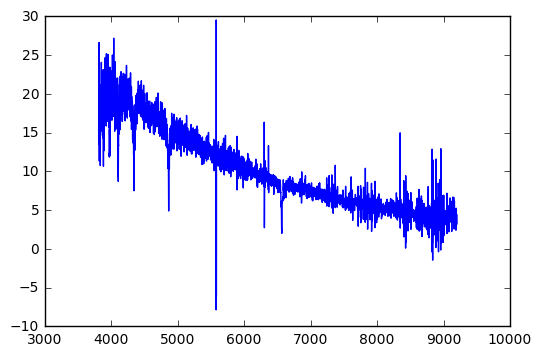

In [25]:
plt.plot(all_lambda,all_flux)

6563.02734375


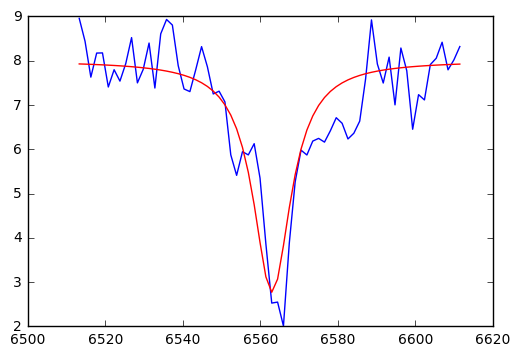

In [44]:
window = np.where(np.logical_and(all_lambda>= (line - 50), all_lambda<= (line + 50)))[0]

plt.plot(all_lambda[window], all_flux[window])

print x_true
plt.plot(all_lambda[window], absorb_lorentz(8,   C_true,   6.56302734e+03, gamma_true, all_lambda[window]), color='red')

In [77]:
print nll([8.1193279e+00+1,   14.67441101e+01,   6.56552734e+03, 7.672009523752565],all_lambda[window], all_flux[window])


72.9816


In [102]:
result = op.minimize(nll, [8.1193279e+00,   14.67441101e+01,   6.56552734e+03, 7.672009523752565], args=(all_lambda[window],all_flux[window]), \
                     tol=1e-2, jac=[])

In [98]:
print result

      fun: 35.754223
 hess_inv: array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])
      jac: array([ 0.,  0.,  0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 6
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([    8.1193279 ,   146.7441101 ,  6565.52734   ,     7.67200952])


In [28]:
print gamma_true

5.88958596618


In [95]:
print approx_jacobian([    8.1193279 ,   146.7441101 ,  6565.52734   ,     7.67200952],nll,,all_lambda[window],all_flux[window])

[[-22.17266083   0.68408966   4.35287476  -5.81378937]]


In [101]:
for stuff in [1.e-7,1.e-6,1.e-5,1.e-4,1.e-3,1.e-2,1.e-1,1.e0]:
    print approx_jacobian([    8.1193279 ,   146.7441101 ,  6565.52734   ,     7.67200952],nll,stuff,all_lambda[window],all_flux[window])

[[ 0.  0.  0.  0.]]
[[-26.70288086   0.           0.          -7.62939453]]
[[-29.75463867   0.76293945   0.          -6.10351562]]
[[-28.80096436   0.72479248   0.          -5.98907471]]
[[-28.71322441   0.68664545   4.02069092  -6.06536818]]
[[-28.11317444   0.68244934   4.03404236  -6.04324341]]
[[-22.17266083   0.68408966   4.35287476  -5.81378937]]
[[ 37.22740555   0.69638062   6.42884827  -3.8596344 ]]
